# Parameter Inference from 21 cm power spectra 

## pyPIPS.datasets

In [1]:
import os, pickle
import numpy as np
from py21cmemu import Emulator
emu = Emulator()

from pyPIPS.datasets import Datapoint, Dataset

2023-05-26 13:40:38.128077: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 13:40:56.121916: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-26 13:41:23.190161: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
def get_21cm_ps_and_tau(params):
    theta, output, output_errors = emu.predict(params)
    return Datapoint(ks=np.arange(60), zs=np.arange(12), P_kz=output["PS"], params={"tau": output["tau"]})

In [3]:
dataset_save_file = "./data/21cm_tau.pkl"
if os.path.exists(dataset_save_file):
    with open(dataset_save_file, "rb") as f:
        dataset = pickle.load(f)
else:
    dataset = Dataset()
    dataset.generate_from_func(get_21cm_ps_and_tau, 10000, \
                           {'F_STAR10': [0, 1], 'ALPHA_STAR': [0, 1], 'F_ESC10': [0, 1], \
                            'ALPHA_ESC': [0, 1], 'M_TURN': [0, 1], 't_STAR': [0, 1], \
                            'L_X': [0, 1], 'NU_X_THRESH': [0, 1], 'X_RAY_SPEC_INDEX': [0, 1]}, gen_params_not_data_params=True)
    dataset.save(dataset_save_file)

In [4]:
train, val, test = dataset.split([0.8, 0.1, 0.1])

print(train.P_kzs.shape)

100%|██████████| 1000/1000 [00:00<00:00, 3867.28it/s]

(8000, 60, 12)


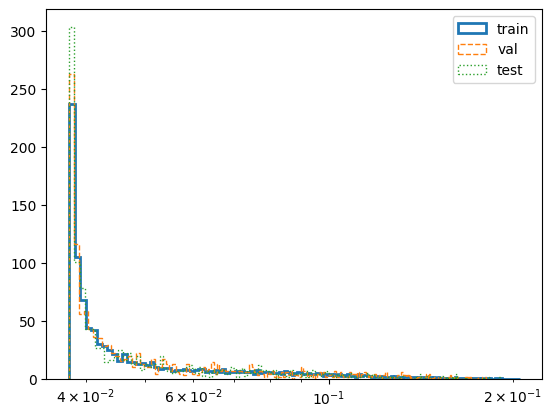

In [24]:
from matplotlib import pyplot as plt

plt.figure()
plt.hist(train.all_parameters[:,0], bins=200, histtype="step", label="train", density=True, linewidth=2)
plt.hist(val.all_parameters[:,0], bins=200, histtype="step", label="val", density=True, linestyle="--")
plt.hist(test.all_parameters[:,0], bins=200, histtype="step", label="test", density=True, linestyle=":")
plt.xscale("log")
plt.legend()
plt.show()
plt.close()

## pyPIPS.models

In [9]:
from pyPIPS.models import BayConvPIPS
import tensorflow as tf

model = BayConvPIPS(train)
model.generate()
model.compile()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_flipout_4 (Conv2DFli  (None, 60, 12, 4)        36        
 pout)                                                           
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 6, 4)         0         
 2D)                                                             
                                                                 
 conv2d_flipout_5 (Conv2DFli  (None, 30, 6, 8)         264       
 pout)                                                           
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 15, 3, 8)         0         
 2D)                                                             
                                                                 
 conv2d_flipout_6 (Conv2DFli  (None, 15, 3, 16)       

In [26]:
model.fit(epochs=20, verbose=2, val_dataset=val)

Epoch 1/20
250/250 - 2s - loss: -5.3960e-01 - mse: 1.1983e-04 - mae: 0.0078 - val_loss: -4.7696e-01 - val_mse: 1.3473e-04 - val_mae: 0.0085 - 2s/epoch - 9ms/step
Epoch 2/20
250/250 - 2s - loss: -6.1601e-01 - mse: 1.1375e-04 - mae: 0.0076 - val_loss: -5.8875e-01 - val_mse: 1.2240e-04 - val_mae: 0.0081 - 2s/epoch - 8ms/step
Epoch 3/20
250/250 - 2s - loss: -6.4727e-01 - mse: 1.1822e-04 - mae: 0.0078 - val_loss: -6.5004e-01 - val_mse: 1.2567e-04 - val_mae: 0.0083 - 2s/epoch - 8ms/step
Epoch 4/20
250/250 - 2s - loss: -7.1664e-01 - mse: 1.1620e-04 - mae: 0.0077 - val_loss: -7.9731e-01 - val_mse: 9.3210e-05 - val_mae: 0.0072 - 2s/epoch - 8ms/step
Epoch 5/20
250/250 - 2s - loss: -7.7587e-01 - mse: 1.2021e-04 - mae: 0.0078 - val_loss: -7.4568e-01 - val_mse: 1.1274e-04 - val_mae: 0.0075 - 2s/epoch - 8ms/step
Epoch 6/20
250/250 - 2s - loss: -8.6181e-01 - mse: 1.1123e-04 - mae: 0.0076 - val_loss: -8.6866e-01 - val_mse: 1.1587e-04 - val_mae: 0.0077 - 2s/epoch - 8ms/step
Epoch 7/20
250/250 - 2s - lo

In [27]:
model.epochs

[50, 20]

In [28]:
n_pred = 20
predictions = np.empty((n_pred, *val.all_parameters.shape))
for i in range(n_pred):
    predictions[i] = model.predict(val, verbose=0)
predictions_best = np.nanmean(predictions, axis=0)
predictions_std = np.nanstd(predictions, axis=0)

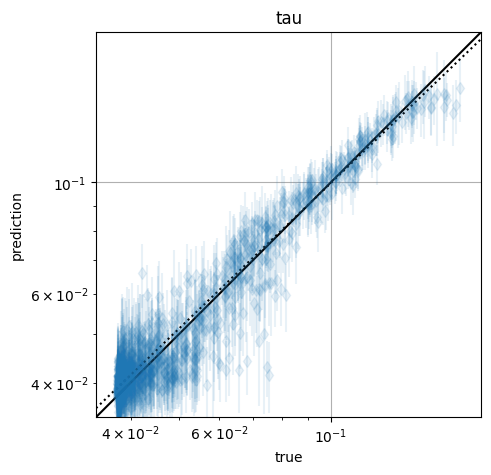

In [31]:
from matplotlib import pyplot as plt

ind = 0
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
fig.subplots_adjust(wspace=0.3, hspace=0.2)
labels = model.parameters
low_lim, upp_lim = np.min(val.all_parameters[:, ind]) / 1.1, np.max(val.all_parameters[:, ind]) * 1.1
p = np.poly1d(np.polyfit(val.all_parameters[:, ind], predictions_best[:, ind], 1))
ax.errorbar(val.all_parameters[:, ind], predictions_best[:, ind],  predictions_std[:, ind], marker="d", ls='none', alpha=0.1)
ax.set_xlabel("true")
ax.set_ylabel("prediction")
ax.plot([low_lim, upp_lim], [low_lim, upp_lim], color="black")
ax.plot([low_lim, upp_lim], [p(low_lim), p(upp_lim)], color="black", ls=":")
ax.set_xlim([low_lim, upp_lim])
ax.set_ylim([low_lim, upp_lim])
ax.set_aspect('equal', adjustable='box')
ax.set_title(labels[0])
ax.loglog()
ax.grid()
plt.show()
plt.close()

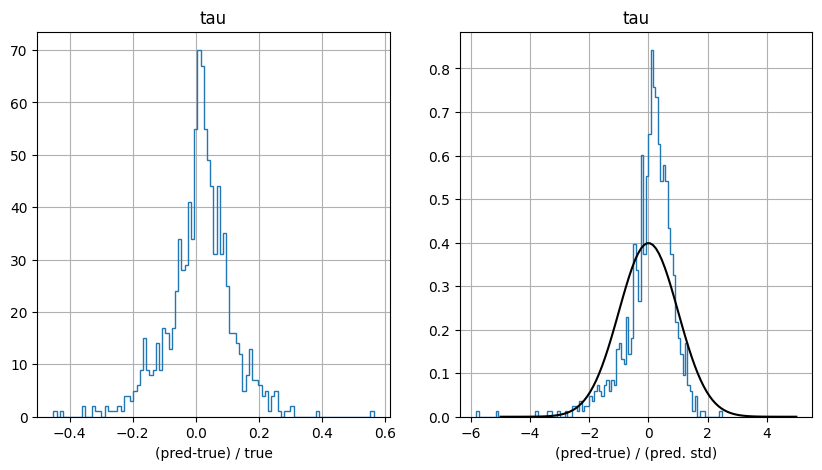

In [39]:
from matplotlib import pyplot as plt

ind = 0
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
labels = model.parameters
ax1.hist((predictions_best[:, ind] - val.all_parameters[:, ind]) / val.all_parameters[:, ind], bins=100, histtype="step")
ax1.set_xlabel("(pred-true) / true")
ax1.set_title(labels[0])
ax1.grid()

ax2.hist((predictions_best[:, ind] - val.all_parameters[:, ind]) / predictions_std[:, ind], bins=100, histtype="step", density=True)
ax2.plot(np.linspace(-5, 5, 100), np.exp(-0.5 * np.linspace(-5, 5, 100)**2) / np.sqrt(2 * np.pi), color="black")
ax2.set_xlabel("(pred-true) / (pred. std)")
ax2.set_title(labels[0])
ax2.grid()

plt.show()
plt.close()

## pyPIPS.optimize

In [40]:
from pyPIPS import optimize
import importlib
importlib.reload(optimize)

optimizer = optimize.BayConvPIPSOptimizer(train, val, epochs=80)
optimizer.optimize(n_trials=20)

/global/cfs/cdirs/des/shubh/.conda/envs/pips/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2023-05-26 14:05:17,510] A new study created in memory with name: no-name-b84e3dbf-f859-4833-9e79-c71778ae27e7
/global/cfs/cdirs/des/shubh/.conda/envs/pips/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/global/cfs/cdirs/des/shubh/.conda/envs/pips/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


14:05:23, epoch 0: loss: 5.507	mse: 0.028	mae: 0.118	
14:06:02, epoch 15: loss: 1.881	mse: 0.000	mae: 0.009	
14:06:39, epoch 30: loss: 0.665	mse: 0.000	mae: 0.007	
14:07:17, epoch 45: loss: -0.078	mse: 0.000	mae: 0.006	
14:07:54, epoch 60: loss: -0.674	mse: 0.000	mae: 0.006	
14:08:30, epoch 75: loss: -1.050	mse: 0.000	mae: 0.006	


[I 2023-05-26 14:08:41,329] Trial 0 finished with value: -1.1744543313980103 and parameters: {'n_conv': 4, 'log2(f_conv0)': 5, 'log2(f_conv1)': 3, 'log2(f_conv2)': 3, 'log2(f_conv3)': 3, 'kernel0': 4, 'kernel1': 4, 'kernel2': 3, 'kernel3': 4, 'n_dense': 3, 'log2(f_dense0)': 7, 'log2(f_dense1)': 6, 'log2(f_dense2)': 5}. Best is trial 0 with value: -1.1744543313980103.


14:08:45, epoch 0: loss: 7.087	mse: 0.138	mae: 0.198	
14:09:07, epoch 15: loss: 0.899	mse: 0.000	mae: 0.007	
14:09:29, epoch 30: loss: -0.954	mse: 0.000	mae: 0.006	
14:09:52, epoch 45: loss: -1.837	mse: 0.000	mae: 0.006	
14:10:14, epoch 60: loss: -2.246	mse: 0.000	mae: 0.006	
14:10:36, epoch 75: loss: -2.554	mse: 0.000	mae: 0.005	


[I 2023-05-26 14:10:43,379] Trial 1 finished with value: -2.7444205284118652 and parameters: {'n_conv': 2, 'log2(f_conv0)': 2, 'log2(f_conv1)': 3, 'kernel0': 4, 'kernel1': 5, 'n_dense': 2, 'log2(f_dense0)': 6, 'log2(f_dense1)': 5}. Best is trial 1 with value: -2.7444205284118652.


14:10:47, epoch 0: loss: 16.716	mse: 0.299	mae: 0.319	
14:11:12, epoch 15: loss: 4.508	mse: 0.000	mae: 0.009	
14:11:35, epoch 30: loss: 0.988	mse: 0.000	mae: 0.009	
14:11:58, epoch 45: loss: -0.126	mse: 0.000	mae: 0.010	
14:12:20, epoch 60: loss: -0.915	mse: 0.000	mae: 0.009	
14:12:42, epoch 75: loss: -1.484	mse: 0.000	mae: 0.008	


[I 2023-05-26 14:12:49,173] Trial 2 finished with value: -1.4606823921203613 and parameters: {'n_conv': 2, 'log2(f_conv0)': 2, 'log2(f_conv1)': 3, 'kernel0': 2, 'kernel1': 3, 'n_dense': 2, 'log2(f_dense0)': 7, 'log2(f_dense1)': 6}. Best is trial 1 with value: -2.7444205284118652.


14:12:53, epoch 0: loss: 13.640	mse: 0.055	mae: 0.087	
14:13:25, epoch 15: loss: 4.402	mse: 0.000	mae: 0.008	
14:14:00, epoch 30: loss: 1.190	mse: 0.000	mae: 0.007	
14:14:29, epoch 45: loss: -0.088	mse: 0.000	mae: 0.007	
14:14:52, epoch 60: loss: -1.038	mse: 0.000	mae: 0.007	
14:15:14, epoch 75: loss: -1.548	mse: 0.000	mae: 0.007	


[I 2023-05-26 14:15:21,804] Trial 3 finished with value: -1.3443901538848877 and parameters: {'n_conv': 2, 'log2(f_conv0)': 2, 'log2(f_conv1)': 3, 'kernel0': 5, 'kernel1': 4, 'n_dense': 2, 'log2(f_dense0)': 7, 'log2(f_dense1)': 5}. Best is trial 1 with value: -2.7444205284118652.


14:15:26, epoch 0: loss: 22.878	mse: 0.149	mae: 0.229	
14:16:01, epoch 15: loss: 5.625	mse: 0.000	mae: 0.008	
14:16:49, epoch 30: loss: 1.223	mse: 0.000	mae: 0.007	
14:17:38, epoch 45: loss: 0.030	mse: 0.000	mae: 0.008	
14:18:27, epoch 60: loss: -0.771	mse: 0.000	mae: 0.007	
14:19:15, epoch 75: loss: -1.081	mse: 0.000	mae: 0.009	


[I 2023-05-26 14:19:29,004] Trial 4 finished with value: -0.6633648872375488 and parameters: {'n_conv': 3, 'log2(f_conv0)': 5, 'log2(f_conv1)': 2, 'log2(f_conv2)': 5, 'kernel0': 2, 'kernel1': 3, 'kernel2': 2, 'n_dense': 2, 'log2(f_dense0)': 7, 'log2(f_dense1)': 6}. Best is trial 1 with value: -2.7444205284118652.


14:19:34, epoch 0: loss: 21.609	mse: 0.109	mae: 0.130	
14:20:12, epoch 15: loss: 8.606	mse: 0.000	mae: 0.009	
14:20:49, epoch 30: loss: 4.070	mse: 0.000	mae: 0.009	
14:21:26, epoch 45: loss: 2.505	mse: 0.000	mae: 0.010	
14:22:03, epoch 60: loss: 1.623	mse: 0.000	mae: 0.010	
14:22:39, epoch 75: loss: 0.721	mse: 0.000	mae: 0.009	


[I 2023-05-26 14:22:50,775] Trial 5 finished with value: 0.4391018748283386 and parameters: {'n_conv': 3, 'log2(f_conv0)': 2, 'log2(f_conv1)': 2, 'log2(f_conv2)': 4, 'kernel0': 5, 'kernel1': 4, 'kernel2': 4, 'n_dense': 2, 'log2(f_dense0)': 8, 'log2(f_dense1)': 5}. Best is trial 1 with value: -2.7444205284118652.


14:22:57, epoch 0: loss: 10.749	mse: 0.090	mae: 0.141	
14:23:38, epoch 15: loss: 4.255	mse: 0.000	mae: 0.007	
14:24:18, epoch 30: loss: 2.159	mse: 0.000	mae: 0.007	
14:24:59, epoch 45: loss: 1.039	mse: 0.000	mae: 0.007	
14:25:40, epoch 60: loss: 0.657	mse: 0.000	mae: 0.008	
14:26:21, epoch 75: loss: 0.152	mse: 0.000	mae: 0.008	


[I 2023-05-26 14:27:18,221] Trial 6 finished with value: -0.009769418276846409 and parameters: {'n_conv': 4, 'log2(f_conv0)': 3, 'log2(f_conv1)': 3, 'log2(f_conv2)': 5, 'log2(f_conv3)': 4, 'kernel0': 5, 'kernel1': 4, 'kernel2': 2, 'kernel3': 4, 'n_dense': 3, 'log2(f_dense0)': 7, 'log2(f_dense1)': 7, 'log2(f_dense2)': 5}. Best is trial 1 with value: -2.7444205284118652.


14:27:25, epoch 0: loss: 57.460	mse: 0.198	mae: 0.165	
14:28:11, epoch 15: loss: 15.634	mse: 0.000	mae: 0.008	
14:28:41, epoch 30: loss: 5.414	mse: 0.000	mae: 0.008	
14:29:06, epoch 45: loss: 1.744	mse: 0.000	mae: 0.008	
14:29:32, epoch 60: loss: 0.326	mse: 0.000	mae: 0.009	
14:29:58, epoch 75: loss: -0.835	mse: 0.000	mae: 0.007	


[I 2023-05-26 14:30:05,584] Trial 7 finished with value: -0.7220550179481506 and parameters: {'n_conv': 2, 'log2(f_conv0)': 3, 'log2(f_conv1)': 5, 'kernel0': 5, 'kernel1': 3, 'n_dense': 2, 'log2(f_dense0)': 7, 'log2(f_dense1)': 5}. Best is trial 1 with value: -2.7444205284118652.


14:30:10, epoch 0: loss: 7.942	mse: 0.085	mae: 0.219	
14:30:39, epoch 15: loss: 2.360	mse: 0.000	mae: 0.009	
14:31:08, epoch 30: loss: 0.565	mse: 0.000	mae: 0.008	
14:31:37, epoch 45: loss: -0.264	mse: 0.000	mae: 0.009	
14:32:06, epoch 60: loss: -0.843	mse: 0.000	mae: 0.008	
14:32:35, epoch 75: loss: -1.236	mse: 0.000	mae: 0.008	


[I 2023-05-26 14:32:44,019] Trial 8 finished with value: -0.8435709476470947 and parameters: {'n_conv': 3, 'log2(f_conv0)': 3, 'log2(f_conv1)': 5, 'log2(f_conv2)': 4, 'kernel0': 3, 'kernel1': 2, 'kernel2': 5, 'n_dense': 2, 'log2(f_dense0)': 5, 'log2(f_dense1)': 7}. Best is trial 1 with value: -2.7444205284118652.


14:32:47, epoch 0: loss: 11.921	mse: 0.156	mae: 0.300	
14:33:17, epoch 15: loss: 3.648	mse: 0.000	mae: 0.016	
14:33:46, epoch 30: loss: 1.279	mse: 0.000	mae: 0.016	
14:34:16, epoch 45: loss: 0.184	mse: 0.000	mae: 0.016	
14:34:46, epoch 60: loss: -0.431	mse: 0.000	mae: 0.016	
14:35:15, epoch 75: loss: -0.670	mse: 0.001	mae: 0.018	


[I 2023-05-26 14:35:24,412] Trial 9 finished with value: -0.8675326108932495 and parameters: {'n_conv': 2, 'log2(f_conv0)': 4, 'log2(f_conv1)': 4, 'kernel0': 3, 'kernel1': 5, 'n_dense': 2, 'log2(f_dense0)': 5, 'log2(f_dense1)': 8}. Best is trial 1 with value: -2.7444205284118652.


14:35:29, epoch 0: loss: 62.927	mse: 0.960	mae: 0.546	
14:35:59, epoch 15: loss: 34.941	mse: 6.181	mae: 1.596	
14:36:30, epoch 30: loss: 18.779	mse: 0.112	mae: 0.134	
14:37:00, epoch 45: loss: 13.309	mse: 0.383	mae: 0.332	
14:37:31, epoch 60: loss: 8.470	mse: 0.010	mae: 0.050	
14:38:01, epoch 75: loss: 5.662	mse: 0.001	mae: 0.021	


[I 2023-05-26 14:38:10,628] Trial 10 finished with value: 5.59382438659668 and parameters: {'n_conv': 2, 'log2(f_conv0)': 4, 'log2(f_conv1)': 4, 'kernel0': 4, 'kernel1': 5, 'n_dense': 4, 'log2(f_dense0)': 6, 'log2(f_dense1)': 8, 'log2(f_dense2)': 8, 'log2(f_dense3)': 8}. Best is trial 1 with value: -2.7444205284118652.


14:38:15, epoch 0: loss: 13.124	mse: 0.058	mae: 0.173	
14:38:36, epoch 15: loss: 7.410	mse: 0.000	mae: 0.012	
14:38:57, epoch 30: loss: 4.969	mse: 0.000	mae: 0.012	
14:39:19, epoch 45: loss: 3.056	mse: 0.000	mae: 0.011	
14:39:40, epoch 60: loss: 1.614	mse: 0.000	mae: 0.011	
14:40:01, epoch 75: loss: 0.622	mse: 0.000	mae: 0.012	


[I 2023-05-26 14:40:08,536] Trial 11 finished with value: 0.33253613114356995 and parameters: {'n_conv': 2, 'log2(f_conv0)': 2, 'log2(f_conv1)': 3, 'kernel0': 2, 'kernel1': 2, 'n_dense': 3, 'log2(f_dense0)': 6, 'log2(f_dense1)': 6, 'log2(f_dense2)': 8}. Best is trial 1 with value: -2.7444205284118652.


14:40:13, epoch 0: loss: 18.690	mse: 0.092	mae: 0.186	
14:40:40, epoch 15: loss: 6.926	mse: 0.000	mae: 0.008	
14:41:07, epoch 30: loss: 3.273	mse: 0.000	mae: 0.008	
14:41:34, epoch 45: loss: 1.716	mse: 0.000	mae: 0.008	
14:42:01, epoch 60: loss: 0.821	mse: 0.000	mae: 0.007	
14:42:29, epoch 75: loss: 0.171	mse: 0.000	mae: 0.008	


[I 2023-05-26 14:42:37,661] Trial 12 finished with value: -0.059238500893116 and parameters: {'n_conv': 2, 'log2(f_conv0)': 2, 'log2(f_conv1)': 2, 'kernel0': 3, 'kernel1': 3, 'n_dense': 4, 'log2(f_dense0)': 8, 'log2(f_dense1)': 5, 'log2(f_dense2)': 7, 'log2(f_dense3)': 5}. Best is trial 1 with value: -2.7444205284118652.


14:42:41, epoch 0: loss: 4.498	mse: 0.081	mae: 0.202	
14:43:06, epoch 15: loss: 0.475	mse: 0.000	mae: 0.007	
14:43:32, epoch 30: loss: -0.318	mse: 0.000	mae: 0.007	
14:43:57, epoch 45: loss: -0.794	mse: 0.000	mae: 0.007	
14:44:22, epoch 60: loss: -1.130	mse: 0.000	mae: 0.006	
14:44:46, epoch 75: loss: -1.272	mse: 0.000	mae: 0.007	


[I 2023-05-26 14:44:54,479] Trial 13 finished with value: -1.321243405342102 and parameters: {'n_conv': 3, 'log2(f_conv0)': 2, 'log2(f_conv1)': 4, 'log2(f_conv2)': 2, 'kernel0': 4, 'kernel1': 5, 'kernel2': 5, 'n_dense': 3, 'log2(f_dense0)': 6, 'log2(f_dense1)': 6, 'log2(f_dense2)': 6}. Best is trial 1 with value: -2.7444205284118652.


14:44:57, epoch 0: loss: 10.052	mse: 0.181	mae: 0.311	
14:45:17, epoch 15: loss: 2.392	mse: 0.000	mae: 0.013	
14:45:36, epoch 30: loss: -0.040	mse: 0.000	mae: 0.012	
14:45:55, epoch 45: loss: -1.205	mse: 0.000	mae: 0.010	
14:46:15, epoch 60: loss: -1.607	mse: 0.000	mae: 0.010	
14:46:34, epoch 75: loss: -1.854	mse: 0.000	mae: 0.010	


[I 2023-05-26 14:46:40,583] Trial 14 finished with value: -2.054281711578369 and parameters: {'n_conv': 2, 'log2(f_conv0)': 3, 'log2(f_conv1)': 3, 'kernel0': 2, 'kernel1': 3, 'n_dense': 2, 'log2(f_dense0)': 6, 'log2(f_dense1)': 7}. Best is trial 1 with value: -2.7444205284118652.


14:46:45, epoch 0: loss: 3.975	mse: 0.036	mae: 0.125	
14:47:10, epoch 15: loss: 0.727	mse: 0.000	mae: 0.010	
14:47:34, epoch 30: loss: -0.197	mse: 0.000	mae: 0.008	
14:47:57, epoch 45: loss: -0.731	mse: 0.000	mae: 0.007	
14:48:21, epoch 60: loss: -1.173	mse: 0.000	mae: 0.007	
14:48:44, epoch 75: loss: -1.498	mse: 0.000	mae: 0.006	


[I 2023-05-26 14:48:51,194] Trial 15 finished with value: -1.6939412355422974 and parameters: {'n_conv': 3, 'log2(f_conv0)': 3, 'log2(f_conv1)': 4, 'log2(f_conv2)': 2, 'kernel0': 3, 'kernel1': 2, 'kernel2': 3, 'n_dense': 3, 'log2(f_dense0)': 5, 'log2(f_dense1)': 7, 'log2(f_dense2)': 6}. Best is trial 1 with value: -2.7444205284118652.


14:48:54, epoch 0: loss: 6.887	mse: 0.204	mae: 0.325	
14:49:18, epoch 15: loss: 1.610	mse: 0.000	mae: 0.009	
14:49:42, epoch 30: loss: 1.298	mse: 0.108	mae: 0.146	
14:50:06, epoch 45: loss: -0.717	mse: 0.001	mae: 0.015	
14:50:30, epoch 60: loss: -1.495	mse: 0.000	mae: 0.009	
14:50:53, epoch 75: loss: -1.550	mse: 0.001	mae: 0.015	


[I 2023-05-26 14:51:01,075] Trial 16 finished with value: -2.1891260147094727 and parameters: {'n_conv': 2, 'log2(f_conv0)': 4, 'log2(f_conv1)': 2, 'kernel0': 4, 'kernel1': 5, 'n_dense': 2, 'log2(f_dense0)': 6, 'log2(f_dense1)': 7}. Best is trial 1 with value: -2.7444205284118652.


14:51:06, epoch 0: loss: 18.856	mse: 0.069	mae: 0.130	
14:51:37, epoch 15: loss: 7.896	mse: 0.000	mae: 0.007	
14:52:07, epoch 30: loss: 4.830	mse: 0.000	mae: 0.008	
14:52:50, epoch 45: loss: 3.574	mse: 0.000	mae: 0.007	
14:53:39, epoch 60: loss: 2.683	mse: 0.000	mae: 0.008	
14:54:28, epoch 75: loss: 2.244	mse: 0.000	mae: 0.011	


[I 2023-05-26 14:54:42,947] Trial 17 finished with value: 1.8702690601348877 and parameters: {'n_conv': 4, 'log2(f_conv0)': 4, 'log2(f_conv1)': 2, 'log2(f_conv2)': 3, 'log2(f_conv3)': 5, 'kernel0': 4, 'kernel1': 5, 'kernel2': 4, 'kernel3': 2, 'n_dense': 4, 'log2(f_dense0)': 6, 'log2(f_dense1)': 8, 'log2(f_dense2)': 7, 'log2(f_dense3)': 5}. Best is trial 1 with value: -2.7444205284118652.


14:54:50, epoch 0: loss: 1.985	mse: 0.043	mae: 0.153	
14:55:35, epoch 15: loss: -1.147	mse: 0.000	mae: 0.009	


In [ ]:
# model = optimizer.get_best_model()
print(optimizer.get_best_params())

19:39:48, epoch 0: loss: 42.895	mse: 1.373	mae: 0.908	
19:40:10, epoch 15: loss: 28.347	mse: 0.201	mae: 0.354	
19:40:33, epoch 30: loss: 17.423	mse: 0.146	mae: 0.301	
19:40:56, epoch 45: loss: 11.807	mse: 0.135	mae: 0.287	
19:41:18, epoch 60: loss: 8.898	mse: 0.133	mae: 0.282	
19:41:41, epoch 75: loss: 7.134	mse: 0.132	mae: 0.280	
19:42:03, epoch 90: loss: 5.996	mse: 0.130	mae: 0.279	
{}


In [ ]:
optimizer.study.best_params['n_dense']

KeyError: 'n_dense'